<h2><center><font color="black"><strong>Model for flats in Paris</strong></font></center></h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
    # Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

    # Pipeline & Preprocess
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

    # Scores
from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error , r2_score
from sklearn.metrics import mean_absolute_percentage_error

#### Import de la base

In [4]:
#df_Paris = pd.read_csv('../Data/update_data/df_Paris_Processed_Louise.csv', low_memory = False, encoding = 'latin1')
df = pd.read_csv('../Data/df_Paris_appartement_vf.csv', low_memory = False, encoding = 'latin1')

In [90]:
min_prix = np.quantile(df.Prix_m2, 0.001)
max_prix = np.quantile(df.Prix_m2, 0.9999)

df = df[(df.Prix_m2 < max_prix)
                        & (df.Prix_m2 > min_prix)
                        & (df.code_type_local == 2)]

**Run helpers**

In [91]:
%run '../Helpers/Data_Process.py'

In [92]:
%run '../Helpers/Models.py'

In [93]:
%run '../Helpers/Data_visualisation.py'

#### Visualisation de la base

In [94]:
df.head(4)

,id_mutation,date_mutation,code_type_local,code_commune,surface_terrain,surface_reelle_bati,nombre_pieces_principales,nature_culture,valeur_fonciere,latitude,longitude,nombre_lots,numero_disposition,code_departement,Nombre_unite,Nombre_dependance,Year,num_trimestre,quarter,geometry,index_right,epci_name,iris_code,iris_name,iris_name_l,Prix_m2,Month,Pris_m2_moy_iris,std,Vente_par_iris,Vente_par_iris_tri,N_logements,N_res_ppale,N_res_second,N_vacant,N_maisons,N_apparts,N_proprietaire,N_locataire,DISP_MED19,Ec_maternelle,Ec_elementaire,P19_LOG,P19_RP_SDB,P19_RP_CCCOLL,P19_RP_CCIND,P19_RP_CINDELEC,UU2020,COM,TRIRIS,GRD_QUART,TYP_IRIS,P19_POP1564,P19_POP1524,P19_POP2554,P19_POP5564,P19_ACT1564,P19_CHOM1564,P19_INACT1564,Part_dactifs,Part_chomeurs,Arrondissement,dist_metro,dist_metro_dummy,Nombre_dependance_dummy,Ec_maternelle_dummy,Ec_elementaire_dummy
0,2017-731653,2017-07-04,2.0,75103,0.0,42.0,3.0,0,571110.0,48.858043,2.366404,2,1,75,1,0,2017,3,2017_Q3,POINT (2.366404 48.858043),17739.0,['MÃÂ©tropole du Grand Paris'],751031102,Les Archives,les archives 2,13597.857143,7,11917.531985,4187.643956,145,11,1229.0,962.0,193.0,74.0,0.0,1226.0,328.0,598.0,41090,0,1,1226.492161,903.973555,212.389497,337.252944,405.049023,851,75103,750081,7510311,H,1151.465277,168.611918,792.332141,190.521218,948.557229,80.312175,202.908048,0.823783,0.069748,75103,124.029509,1,0,0,1
1,2017-731668,2017-07-07,2.0,75103,0.0,88.0,3.0,0,1414600.0,48.857626,2.364992,2,1,75,1,1,2017,3,2017_Q3,POINT (2.364992 48.857626),17739.0,['MÃÂ©tropole du Grand Paris'],751031102,Les Archives,les archives 2,16075.000000,7,11917.531985,4187.643956,145,11,1229.0,962.0,193.0,74.0,0.0,1226.0,328.0,598.0,41090,0,1,1226.492161,903.973555,212.389497,337.252944,405.049023,851,75103,750081,7510311,H,1151.465277,168.611918,792.332141,190.521218,948.557229,80.312175,202.908048,0.823783,0.069748,75103,215.449398,1,1,0,1
2,2017-731783,2017-07-19,2.0,75103,0.0,17.0,1.0,0,215000.0,48.856136,2.366991,1,1,75,1,0,2017,3,2017_Q3,POINT (2.366991 48.856136),17739.0,['MÃÂ©tropole du Grand Paris'],751031102,Les Archives,les archives 2,12647.058824,7,11917.531985,4187.643956,145,11,1229.0,962.0,193.0,74.0,0.0,1226.0,328.0,598.0,41090,0,1,1226.492161,903.973555,212.389497,337.252944,405.049023,851,75103,750081,7510311,H,1151.465277,168.611918,792.332141,190.521218,948.557229,80.312175,202.908048,0.823783,0.069748,75103,173.202049,1,0,0,1
3,2017-731808,2017-07-27,2.0,75103,0.0,72.0,3.0,0,598000.0,48.857626,2.364992,1,1,75,1,0,2017,3,2017_Q3,POINT (2.364992 48.857626),17739.0,['MÃÂ©tropole du Grand Paris'],751031102,Les Archives,les archives 2,8305.555556,7,11917.531985,4187.643956,145,11,1229.0,962.0,193.0,74.0,0.0,1226.0,328.0,598.0,41090,0,1,1226.492161,903.973555,212.389497,337.252944,405.049023,851,75103,750081,7510311,H,1151.465277,168.611918,792.332141,190.521218,948.557229,80.312175,202.908048,0.823783,0.069748,75103,215.449398,1,0,0,1


In [95]:
dummies_pr_var_continues(df, 'dist_metro', 0.01)
dummies_pr_var_continues(df, 'Nombre_dependance', 0)
dummies_pr_var_continues(df, 'Ec_maternelle', 0)
dummies_pr_var_continues(df, 'Ec_elementaire', 0)

## Split temporel : 

In [96]:
df_train = df[df['date_mutation'] < '2021-04-01']
df_test = df[df['date_mutation'] >= '2021-04-01']

In [97]:
df_train = pd.concat([df_train, pd.get_dummies(df_train[['quarter']])], axis = 1)

In [98]:
df_train['n_pieces_BienStandard'] = df_train['nombre_pieces_principales']-2
df_train['n_dependances_BienStandard'] = df_train['Nombre_dependance']

## Indice de prix : 

In [99]:
features_ols = ['quarter_2017_Q4', 'quarter_2018_Q1', 'quarter_2018_Q2', 'quarter_2018_Q3',
'quarter_2018_Q4', 'quarter_2019_Q1', 'quarter_2019_Q2',
'quarter_2019_Q3', 'quarter_2019_Q4', 'quarter_2020_Q1',
'quarter_2020_Q2', 'quarter_2020_Q3', 'quarter_2020_Q4',
'quarter_2021_Q1',
'n_pieces_BienStandard', 'n_dependances_BienStandard']
outcome = 'Prix_m2'

In [100]:
model = model_OLS_prix(df_train, 'Prix_m2', features_ols, summary = True)

                            OLS Regression Results                            
Dep. Variable:                Prix_m2   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     587.6
Date:                Mon, 03 Apr 2023   Prob (F-statistic):               0.00
Time:                        19:27:00   Log-Likelihood:            -7.0797e+05
No. Observations:               78221   AIC:                         1.416e+06
Df Residuals:                   78204   BIC:                         1.416e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

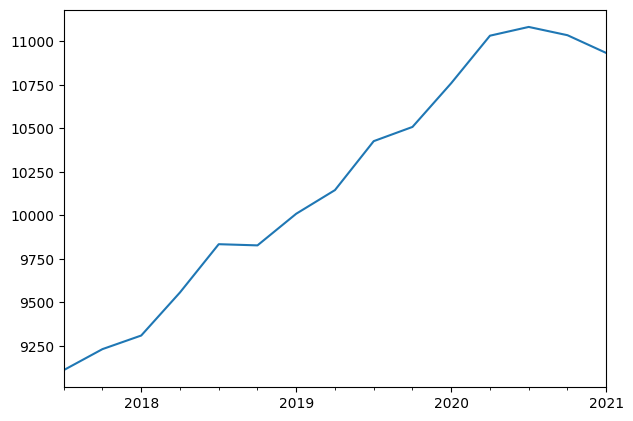

In [101]:
df_train = add_indice_prix(df_train, indice_prix_quarter(model, plot = True))

## Visualisation

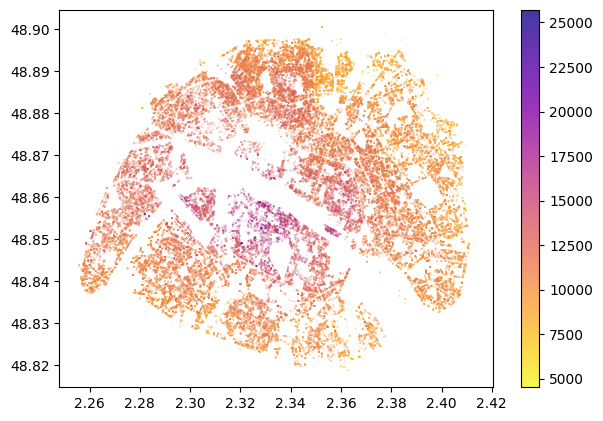

In [102]:
visualise(df, 'Prix_m2')

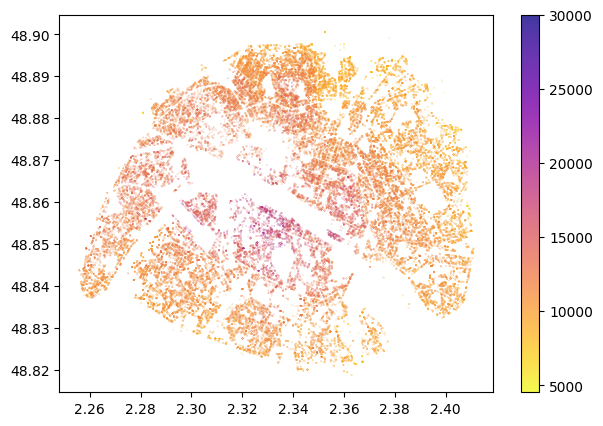

In [103]:
visualise(df_train, 'Prix_m2_actualise_Q1_2021')

## Sélection des features : 

In [104]:
df.columns

Index(['id_mutation', 'date_mutation', 'code_type_local', 'code_commune',
       'surface_terrain', 'surface_reelle_bati', 'nombre_pieces_principales',
       'nature_culture', 'valeur_fonciere', 'latitude', 'longitude',
       'nombre_lots', 'numero_disposition', 'code_departement', 'Nombre_unite',
       'Nombre_dependance', 'Year', 'num_trimestre', 'quarter', 'geometry',
       'index_right', 'epci_name', 'iris_code', 'iris_name', 'iris_name_l',
       'Prix_m2', 'Month', 'Pris_m2_moy_iris', 'std', 'Vente_par_iris',
       'Vente_par_iris_tri', 'N_logements', 'N_res_ppale', 'N_res_second',
       'N_vacant', 'N_maisons', 'N_apparts', 'N_proprietaire', 'N_locataire',
       'DISP_MED19', 'Ec_maternelle', 'Ec_elementaire', 'P19_LOG',
       'P19_RP_SDB', 'P19_RP_CCCOLL', 'P19_RP_CCIND', 'P19_RP_CINDELEC',
       'UU2020', 'COM', 'TRIRIS', 'GRD_QUART', 'TYP_IRIS', 'P19_POP1564',
       'P19_POP1524', 'P19_POP2554', 'P19_POP5564', 'P19_ACT1564',
       'P19_CHOM1564', 'P19_INACT1564', '

In [105]:
df_test_vif = df[['nombre_pieces_principales', 'Nombre_dependance',
                  'Part_chomeurs',
                  'dist_metro',
                 'DISP_MED19',
                 'Ec_maternelle', 'Ec_elementaire',
                #  'N_apparts'
                 ]]

In [106]:
calc_vif(df_test_vif)

,variables,VIF
0,nombre_pieces_principales,5.492388
1,Nombre_dependance,1.422668
2,Part_chomeurs,6.699818
3,dist_metro,3.575274
4,DISP_MED19,8.758170
5,Ec_maternelle,1.662513
6,Ec_elementaire,1.794606


## <center> K plus proches voisins sur la latitude/longitude

Les features sont : 
- pour le KNN : 
    - latitude; longitude
- pour le Random Forest ou GBoost:
    - à compléter

In [107]:
    # Dependant variables : cooridnates
features_knn = ['latitude', 'longitude']
    # Output
label_train = 'Prix_m2_actualise_Q1_2021'
label_test = 'Prix_m2'

In [108]:
knn_pipe = model_KNN_coordinates(df_train, df_test, features_knn,
                          label_train, label_test,
                          MinMaxScaler(), 'uniform', 25, 5)

Returned hyperparameter: {'Knn__n_neighbors': 15}


In [109]:
    # Scores on TRAIN dataset
compute_scores(knn_pipe, df_train[features_knn], df_train[label_train])

MAPE:  10.025402054581997
MDAPE:  7.565596525681043


In [110]:
    # Scores on TEST dataset
compute_scores(knn_pipe, df_test[features_knn], df_test[label_test])

MAPE:  10.3264489083014
MDAPE:  7.9374558082058355


## Etude du score

In [125]:
X_test = df_test.copy()
y_pred = knn_pipe.predict(X_test[features_knn])
X_test["y_pred"] = y_pred
X_test['y_true'] = df_test[label_test]
X_test['mdape'] = np.abs((X_test['y_true'] - X_test["y_pred"])/X_test['y_true'])*100
X_test.head(3)

,id_mutation,date_mutation,code_type_local,code_commune,surface_terrain,surface_reelle_bati,nombre_pieces_principales,nature_culture,valeur_fonciere,latitude,longitude,nombre_lots,numero_disposition,code_departement,Nombre_unite,Nombre_dependance,Year,num_trimestre,quarter,geometry,index_right,epci_name,iris_code,iris_name,iris_name_l,Prix_m2,Month,Pris_m2_moy_iris,std,Vente_par_iris,Vente_par_iris_tri,N_logements,N_res_ppale,N_res_second,N_vacant,N_maisons,N_apparts,N_proprietaire,N_locataire,DISP_MED19,Ec_maternelle,Ec_elementaire,P19_LOG,P19_RP_SDB,P19_RP_CCCOLL,P19_RP_CCIND,P19_RP_CINDELEC,UU2020,COM,TRIRIS,GRD_QUART,TYP_IRIS,P19_POP1564,P19_POP1524,P19_POP2554,P19_POP5564,P19_ACT1564,P19_CHOM1564,P19_INACT1564,Part_dactifs,Part_chomeurs,Arrondissement,dist_metro,dist_metro_dummy,Nombre_dependance_dummy,Ec_maternelle_dummy,Ec_elementaire_dummy,y_pred,y_true,mdape
101,2021-1581950,2021-04-01,2.0,75103,0.0,44.0,3.0,0,710000.0,48.857902,2.366992,3,1,75,1,0,2021,2,2021_Q2,POINT (2.366992 48.857902),17739.0,['MÃÂ©tropole du Grand Paris'],751031102,Les Archives,les archives 2,16136.363636,4,11475.289813,6700.767551,145,8,1229.0,962.0,193.0,74.0,0.0,1226.0,328.0,598.0,41090,0,1,1226.492161,903.973555,212.389497,337.252944,405.049023,851,75103,750081,7510311,H,1151.465277,168.611918,792.332141,190.521218,948.557229,80.312175,202.908048,0.823783,0.069748,75103,78.552883,1,0,0,1,12880.949957,16136.363636,20.174395
102,2021-1582387,2021-04-09,2.0,75103,0.0,45.0,2.0,0,573000.0,48.857871,2.364699,2,1,75,1,0,2021,2,2021_Q2,POINT (2.364699 48.857871),17739.0,['MÃÂ©tropole du Grand Paris'],751031102,Les Archives,les archives 2,12733.333333,4,11475.289813,6700.767551,145,8,1229.0,962.0,193.0,74.0,0.0,1226.0,328.0,598.0,41090,0,1,1226.492161,903.973555,212.389497,337.252944,405.049023,851,75103,750081,7510311,H,1151.465277,168.611918,792.332141,190.521218,948.557229,80.312175,202.908048,0.823783,0.069748,75103,239.229573,1,0,0,1,14282.319759,12733.333333,12.164815
103,2021-1582391,2021-04-14,2.0,75103,0.0,26.0,2.0,0,377505.0,48.856715,2.367546,2,1,75,1,0,2021,2,2021_Q2,POINT (2.367546 48.856715),17739.0,['MÃÂ©tropole du Grand Paris'],751031102,Les Archives,les archives 2,14519.423077,4,11475.289813,6700.767551,145,8,1229.0,962.0,193.0,74.0,0.0,1226.0,328.0,598.0,41090,0,1,1226.492161,903.973555,212.389497,337.252944,405.049023,851,75103,750081,7510311,H,1151.465277,168.611918,792.332141,190.521218,948.557229,80.312175,202.908048,0.823783,0.069748,75103,98.628171,1,0,0,1,12700.411461,14519.423077,12.528126


In [120]:
X_test.groupby('Arrondissement').agg({'mdape' : 'median'}).reset_index().set_index('Arrondissement').T

Arrondissement,75101,75102,75103,75104,75105,75106,75107,75108,75109,75110,75111,75112,75113,75114,75115,75116,75117,75118,75119,75120
mdape,10.830851,8.898006,9.201976,9.108616,8.579083,10.273791,10.088024,9.687568,8.104458,8.118497,7.300893,6.771848,7.603913,7.242332,7.082049,8.55226,7.595243,8.135207,8.181745,7.721891


In [129]:
tab_knn_arr = X_test.groupby('Arrondissement').agg({'mdape' : 'median'}).reset_index().set_index('Arrondissement').T.to_latex()
tab_knn_arr

'\\begin{tabular}{lrrrrrrrrrrrrrrrrrrrr}\n\\toprule\nArrondissement &      75101 &     75102 &     75103 &     75104 &     75105 &      75106 &      75107 &     75108 &     75109 &     75110 &     75111 &     75112 &     75113 &     75114 &     75115 &    75116 &     75117 &     75118 &     75119 &     75120 \\\\\n\\midrule\nmdape &  10.830851 &  8.898006 &  9.201976 &  9.108616 &  8.579083 &  10.273791 &  10.088024 &  9.687568 &  8.104458 &  8.118497 &  7.300893 &  6.771848 &  7.603913 &  7.242332 &  7.082049 &  8.55226 &  7.595243 &  8.135207 &  8.181745 &  7.721891 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [130]:
tab_knn_arr = X_test.groupby('quarter').agg({'mdape' : 'median'}).reset_index().set_index('quarter').T.to_latex()
tab_knn_arr

'\\begin{tabular}{lrrrrr}\n\\toprule\nquarter &   2021\\_Q2 &   2021\\_Q3 &   2021\\_Q4 &   2022\\_Q1 &  2022\\_Q2 \\\\\n\\midrule\nmdape &  7.786354 &  7.716062 &  8.266691 &  7.779771 &  8.04093 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [121]:
fig = px.scatter(X_test, x = 'surface_reelle_bati', y = 'mdape')
fig.update_layout(yaxis_range=[-0.5, 150])
fig.show()

## Random Forest

In [131]:
%run '../Helpers/Models.py'

In [132]:
#features_RF = ['Nombre_dependance_dummy', 'dist_metro_dummy', 'nombre_pieces_principales',
               #'Ec_elementaire_dummy', 'Ec_maternelle_dummy',
#              'N_apparts', 'DISP_MED19', 'Part_chomeurs']
features_RF = ['nombre_pieces_principales', 'Nombre_dependance',
                  'Part_chomeurs',
                  'dist_metro',
                 'DISP_MED19',
                 'Ec_maternelle', 'Ec_elementaire',
                 ]

In [133]:
RF_model = model_RF_post_KNN(df_test, df_train, features_RF, features_knn, label_train, label_test,
                      model_knn = knn_pipe, standardisation = StandardScaler(), range_depth = [5, 10, 15, 20], nb_cv = 5)

In [134]:
X_train_rf = df_train[features_RF]
X_train_rf['y_pred_knn'] = knn_pipe.predict(df_train[features_knn])
X_test_rf = df_test[features_RF]
X_test_rf['y_pred_knn'] = knn_pipe.predict(df_test[features_knn])
compute_scores(RF_model, X_test_rf, df_test[label_test])

MAPE:  10.322105021436665
MDAPE:  7.927117268509345


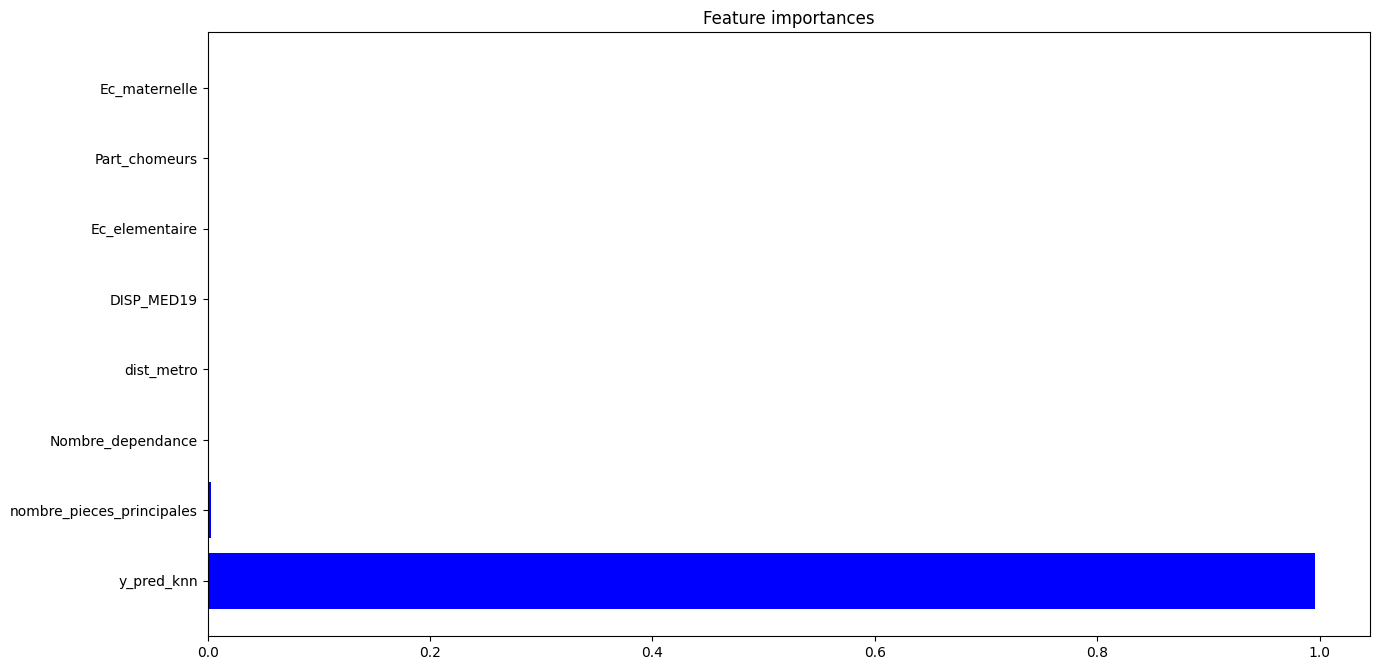

In [135]:
RF_importances = RF_model.best_estimator_.named_steps["RForest"].feature_importances_
features_importances(RF_importances, X_train_rf)

In [136]:
tab_knn_arr = round(X_test.groupby('quarter').agg({'mdape' : 'median'}).reset_index().set_index('quarter').T, 2).to_latex()
tab_knn_arr

'\\begin{tabular}{lrrrrr}\n\\toprule\nquarter &  2021\\_Q2 &  2021\\_Q3 &  2021\\_Q4 &  2022\\_Q1 &  2022\\_Q2 \\\\\n\\midrule\nmdape &     7.79 &     7.72 &     8.27 &     7.78 &     8.04 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [138]:
tab_knn_arr = round(X_test.groupby('Arrondissement').agg({'mdape' : 'median'}).reset_index().set_index('Arrondissement').T, 2).to_latex()
tab_knn_arr

'\\begin{tabular}{lrrrrrrrrrrrrrrrrrrrr}\n\\toprule\nArrondissement &  75101 &  75102 &  75103 &  75104 &  75105 &  75106 &  75107 &  75108 &  75109 &  75110 &  75111 &  75112 &  75113 &  75114 &  75115 &  75116 &  75117 &  75118 &  75119 &  75120 \\\\\n\\midrule\nmdape &  10.83 &    8.9 &    9.2 &   9.11 &   8.58 &  10.27 &  10.09 &   9.69 &    8.1 &   8.12 &    7.3 &   6.77 &    7.6 &   7.24 &   7.08 &   8.55 &    7.6 &   8.14 &   8.18 &   7.72 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Gradient Boost

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('GBoost', GradientBoostingRegressor())])
parameters = {'GBoost__n_estimators': [50, 100, 150]} # defining parameter space
gboost_pipe = GridSearchCV(pipe, parameters, cv=5)
gboost_pipe.fit(X_train_rf, y_train)

compute_scores(gboost_pipe, X_test_rf, y_test)

In [ ]:
gboost_pipe.best_params_

In [ ]:
#dummies_pr_var_continues(df, 'dist_metro', 0.01)

**Features importance**

In [ ]:
model_rf = RandomForestRegressor(max_depth=10)
model_rf.fit(X_train_rf, y_train)

#Prediciton 
y_pred_rf = model_rf.predict(X_test_rf)

importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X_train_rf.columns
# plot
nb_features = X_train_rf.shape[1]
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.barh(
    range(nb_features),
    importances[indices],
    color='b')
plt.yticks(range(nb_features), columns[indices], rotation='horizontal', size=10)
plt.show()

XG BOOST

In [ ]:
df_train.columns

In [ ]:
model_gb = GradientBoostingRegressor(n_estimators = 100)
model_gb.fit(X_train_rf, y_train)

#Prediciton 
y_pred_rf = model_gb.predict(X_test_rf)

importances = model_gb.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X_train_rf.columns
# plot
nb_features = X_train_rf.shape[1]
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.barh(
    range(nb_features),
    importances[indices],
    color='b')
plt.yticks(range(nb_features), columns[indices], rotation='horizontal', size=10)
plt.show()